# Anime Image Generation With different flavors of Variational Auto-Encoders and Generative Adverserial Networks.

In this notebook we will implement different Vanilla VAE, HVAE, GAN to generate anime images.
1. Vanilla VAE
2. Hierarichal VAE
3. DCGAN

The below image gives the higher layer view of VAE and HVAE, we are going to implement.

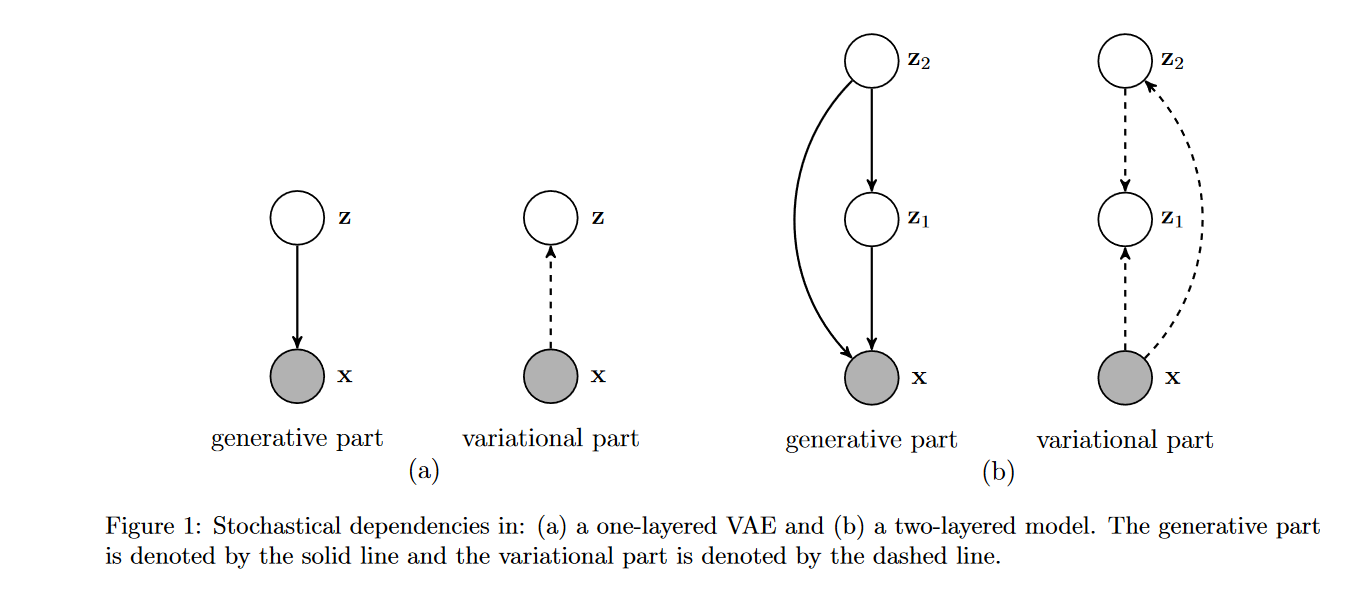

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from pytorch_lightning.core.lightning import LightningModule
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# from pl_bolts.datamodules import CIFAR10DataModule, ImagenetDataModule
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Reading the images
image_names = os.listdir('../input/animefacedataset/images')
print(len(image_names))

In [ ]:
# splitting images into train and validation
train_img_list = image_names[:50000]
val_img_list = image_names[50000:]

## Dataset Class
Now we will create a dataset class for the dataloader

In [ ]:
# Creating a dataset class
class DatasetAnime(Dataset):
    
    def __init__(self,img_list,image_dir,transform=None):
        '''
        Input
        img_list: list of image names
        image_dir: directory of images
        '''
        self.transform = transform
        self.image_dir = image_dir
        self.img_list = img_list
        
    def __len__(self):
        '''
        return length of dataset
        '''
        return len(self.img_list)
    
    def __getitem__(self, index):
        '''
        Input 
        index: image index
        Image is read, standardized and converted into torch variable
        Output: return the image and label(same as image) after converting into torch variable
        '''
        img_path = self.image_dir + self.img_list[index]
        image = Image.open(img_path).convert('RGB')
        label = Image.open(img_path).convert('RGB')
        image = image.resize((64,64))
        label = label.resize((64,64))
        image = np.asarray(image, dtype=np.float32)/255
        label = np.asarray(label, dtype=np.float32)/255
        image = torch.from_numpy(image)
        label = torch.from_numpy(label)

        image = image.permute(2,0,1)
        label = label.permute(2,0,1)

        return image, label

In [ ]:
# Creating the train_loader and validation loader
image_dir = '../input/animefacedataset/images/'
batch_size = 64
train_dataset = DatasetAnime(train_img_list,image_dir,transform=None)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

val_dataset = DatasetAnime(val_img_list,image_dir,transform=None)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
# function to visualize generated sample images
def show_samples(batch_tensor,n_row):
    grid = torchvision.utils.make_grid(batch_tensor, nrow=n_row)
    plt.imshow(grid.permute(1, 2, 0).detach())

## VAE implementation
First we will implement vanilla VAE for generating anime images

In [ ]:
class VAE(LightningModule):
    def __init__(self,in_channels,latent_dim):
        '''
        Input
        in_channels: number of channels of image
        latent_dim: latent dimension for VAE
        
        We will initialize model layers
        '''
        super(VAE, self).__init__()
        hidden_dims = [32,64,128,256]
        self.latent_dim = latent_dim
        modules=[]
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4*4, latent_dim)
        self.avg_train_loss = {'loss': 0, 'Reconstruction_Loss':0, 'KLD':0}
        self.avg_val_loss = {'loss': 0, 'Reconstruction_Loss':0, 'KLD':0}
        self.temp_train = {}
        self.temp_val = {}
        hidden_dims.reverse()
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0]*4*4)

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Sigmoid())
    
    def train_dataloader(self):
        '''
        returning a train_loader
        '''
        return train_loader
    
    def val_dataloader(self):
        '''
        returning val_loader
        '''
        return val_loader
        
    def encode(self,input):
        '''
        Creating Encoder model from encoder layers
        '''
        result = self.encoder(input)

        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var
    
    def decode(self,z):
        '''
        Creating Decoder model from decoder layers
        '''
        result = self.decoder_input(z)
        result = result.view(-1,256 ,4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def reparameterize(self, mu, logvar):
        '''
        Reparameterization
        '''
        std = torch.exp(logvar / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return z
    
    
    def forward(self, input):
        '''
        Forward propagation
        '''
        mu,log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  self.decode(z), mu, log_var
    
    
    def loss_function(self,recons,label,mu,log_var):
        '''
        Loss function comprising of reconstruction loss and KL divergence loss
        '''
        alpha = 2
        MSE = 0.5 * torch.sum(torch.pow(label - recons, 2))
        KLD = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp())
        loss = MSE+ alpha*KLD
        return loss
    
    def sample(self,num_samples):
        '''
        Input
        num_samples: number of samples
        generate image samples from VAE
        '''
        z = torch.randn(num_samples,self.latent_dim)
        samples = self.decode(z)
        return samples
                       
    def generate(self, x):
        '''
        generate a reconstructed image on a real image
        '''
        return self.forward(x)[0]
                       
    def training_step(self, batch, batch_idx):
        '''
        training step for model
        '''
        real_img, label = batch
        recons,mu,log_var = self.forward(real_img)
        train_loss = self.loss_function(recons,label,mu,log_var)
        return train_loss
        
    
    def validation_step(self,batch,batch_idx):
        '''
        validation step for model
        '''
        real_img, label = batch
        recons,mu,log_var = self.forward(real_img)
        val_loss = self.loss_function(recons,label,mu,log_var)
        return val_loss
    
    def configure_optimizers(self):
        '''
        Optimizer for model training
        '''
        return optim.Adam(self.parameters(),lr=1e-3)

## VAE training
Now we will will train the VAE model.

In [ ]:
## model training
model = VAE(3,512)
trainer = pl.Trainer(gpus=1,max_epochs=50)
trainer.fit(model)

In [16]:
# Ploting the Sample Images
x = model.sample(16)

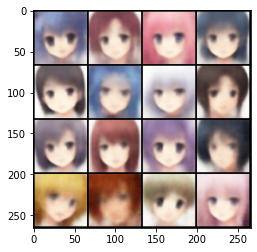

In [17]:
show_samples(x,4)

In [18]:
trainer.save_checkpoint("VAE_50epoch.ckpt")

## HIERARICHAL VAE
Now we will implement Hierarichal VAE. The below is the mathematical interpretation.

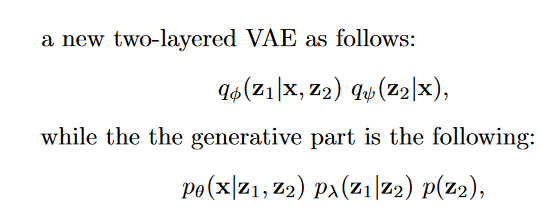

In [ ]:
class HVAE(LightningModule):
    def __init__(self,in_channels,z1_dim = 256, z2_dim = 256):
        '''
        Input
        in_channels: number of channels of image
        z1_dim: latent dimension for z1
        z2_dim: latent dimension for z2
        We will initialize model layers
        '''
        super(HVAE, self).__init__()
        hidden_dims = [32,64,64]
        self.z2_dim = z2_dim
        self.z1_dim = z1_dim
        modules=[]
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
            
        modules.append(nn.Sequential(nn.Conv2d(hidden_dims[2],8,kernel_size= 3, stride= 1, padding  = 1)))
        
        hid_dim = hidden_dims[-1]*8
        self.q_z2_layers = nn.Sequential(*modules)
        self.q_z1_layers_x = nn.Sequential(*modules)
        
        self.q_z2_mean = nn.Linear(hid_dim, self.z2_dim)
        self.q_z2_logvar = nn.Sequential(nn.Linear(hid_dim, self.z2_dim),nn.Hardtanh())
        
        self.q_z1_layers_z2 = nn.Sequential(nn.Linear(self.z2_dim, hid_dim))
        
        self.q_z1_layers_joint = nn.Sequential(
            nn.Linear( 2 * hid_dim, 512)
        )
        
        self.q_z1_mean = nn.Linear(512, self.z1_dim)
        self.q_z1_logvar = nn.Sequential(nn.Linear(512, self.z1_dim),nn.Hardtanh())
        
        self.p_z1_layers = nn.Sequential(
            nn.Linear(self.z2_dim, 512),
            nn.Linear(512, 512)
        )
        self.p_z1_mean = nn.Sequential(nn.Linear(512, self.z1_dim))
        self.p_z1_logvar = nn.Sequential(nn.Linear(512, self.z1_dim),nn.Hardtanh()) 
        
        
        self.p_x_layers_z1 = nn.Sequential(
            nn.Linear(self.z1_dim, 512)
        )
        self.p_x_layers_z2 = nn.Sequential(
            nn.Linear(self.z2_dim, 512)
        )
        
        self.p_x_layers_joint_pre = nn.Sequential(
            nn.Linear(2 * 512, 8*8*64)
        )
        
        hidden_dims.reverse()
        modules = []
        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels=hidden_dims[i], out_channels=hidden_dims[i+1],
                              kernel_size= 3, stride= 2, padding  = 1,output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i+1]),
                    nn.LeakyReLU())
            )
            

        self.p_x_layers_joint = nn.Sequential(*modules)
        self.p_x_mean = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Sigmoid())
        
        self.p_x_logvar = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Hardtanh(min_val=-4.5, max_val=0.)
        )
    
    def train_dataloader(self):
        '''
        returns the train_loader
        '''
        return train_loader
    
    def val_dataloader(self):
        '''
        return the val_loader
        '''
        return val_loader
    
    def q_z2(self, x):
        '''
        Encoder part
        '''
        # processing x
        h = self.q_z2_layers(x)
        h = torch.flatten(h, start_dim=1)
        # predict mean and variance
        z2_q_mean = self.q_z2_mean(h)
        z2_q_logvar = self.q_z2_logvar(h)
        return z2_q_mean, z2_q_logvar
    
    def q_z1(self, x, z2):
        '''
        Encoder part
        '''
        # processing x
        x = self.q_z1_layers_x(x)
        x = x.view(x.size(0),-1)
        # processing z2
        z2 = self.q_z1_layers_z2(z2)
        # concatenating
        h = torch.cat((x,z2),1)
        h = self.q_z1_layers_joint(h)
        # predict mean and variance
        z1_q_mean = self.q_z1_mean(h)
        z1_q_logvar = self.q_z1_logvar(h)
        return z1_q_mean, z1_q_logvar
    
    def p_z1(self, z2):
        '''
        Decoder part
        '''
        z2 = self.p_z1_layers(z2)
        # predict mean and variance
        z1_p_mean = self.p_z1_mean(z2)
        z1_p_logvar = self.p_z1_logvar(z2)
        return z1_p_mean, z1_p_logvar
    
    def p_x(self, z1, z2):
        '''
        Decoder part
        '''
        # processing z2
        z2 = self.p_x_layers_z2(z2)
        # processing z1
        z1 = self.p_x_layers_z1(z1)
        # concatenate x and z1 and z2
        h = torch.cat((z1, z2), 1)
        h = self.p_x_layers_joint_pre(h)
        h = h.view(-1, 64, 8,8)

        # joint decoder part of the decoder
        h_decoder = self.p_x_layers_joint(h)
        x_mean = self.p_x_mean(h_decoder)
        x_logvar =self.p_x_logvar(h_decoder)
        return x_mean, x_logvar
    
    def reparameterize(self,mu, logvar):
        '''
        Reparameterization
        '''
        std = torch.exp(logvar / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return z
    
    def reconstruction_loss(self,recons,x):
        '''
        Reconstruction loss
        '''
        recon_loss = 0.5 * torch.sum(torch.pow(x - recons, 2))
        return recon_loss
    
    def kl_loss_function(self,mu,logvar):
        '''
        KL divergence loss
        '''
        kl_loss = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
        return kl_loss
    
    def loss_function(self,x,x_mean,x_logvar, z1_q, z1_q_mean, z1_q_logvar, z2_q,
                       z2_q_mean, z2_q_logvar, z1_p_mean, z1_p_logvar):
        '''
        loss function
        reconstruction and kl divergence loss
        '''
        recons_loss = self.reconstruction_loss(x_mean,x)
        
        kl_loss_qz1 = self.kl_loss_function(z1_q_mean,z1_q_logvar)
        kl_loss_qz2 = self.kl_loss_function(z2_q_mean,z2_q_logvar)
        kl_loss_pz1 = self.kl_loss_function(z1_p_mean,z1_p_logvar)
        kl_loss_pz2 =  torch.sum(-0.5 * torch.pow(z2_q, 2))

        
        loss = recons_loss + 2*(kl_loss_qz1 + kl_loss_qz2 + kl_loss_pz1 + kl_loss_pz2)
        return loss
        
    def training_step(self, batch, batch_idx):
        '''
        training step for model
        '''
        real_img, label = batch
        x_mean,x_logvar, z1_q, z1_q_mean, z1_q_logvar, z2_q,z2_q_mean,z2_q_logvar,z1_p_mean, z1_p_logvar = self.forward(real_img)
        train_loss = self.loss_function(real_img,x_mean,x_logvar ,z1_q, z1_q_mean, z1_q_logvar, z2_q,
                       z2_q_mean, z2_q_logvar, z1_p_mean, z1_p_logvar)
        return train_loss
    
    def configure_optimizers(self):
        '''
        optimizer for training
        '''
        return optim.Adam(self.parameters(),lr=1e-3)
    
    def generate(self, x):
        '''
        generate a reconstructed image on a real image
        '''
        x_reconstructed, _, _, _, _, _, _, _, _, _ = self.forward(x)
        return x_reconstructed
        
    def sample(self,num_samples):
        '''
        Input
        num_samples: number of samples
        generate image samples from VAE
        '''
        z2 = torch.randn(num_samples,self.z2_dim)
        z1_mean, z1_logvar = self.p_z1(z2)
        z1_rand = self.reparameterize(z1_mean, z1_logvar)
        samples_gen, _ = self.p_x(z1_rand, z2)
        return samples_gen
        
    def forward(self,x):
        '''
        Forward pass
        '''
        # z2 ~ q(z2 | x)
        z2_q_mean, z2_q_logvar = self.q_z2(x)
        z2_q = self.reparameterize(z2_q_mean, z2_q_logvar)

        # z1 ~ q(z1 | x, z2)
        z1_q_mean, z1_q_logvar = self.q_z1(x, z2_q)
        z1_q = self.reparameterize(z1_q_mean, z1_q_logvar)

        # p(z1 | z2)
        z1_p_mean, z1_p_logvar = self.p_z1(z2_q)

        # x_mean = p(x|z1,z2)
        x_mean,x_logvar = self.p_x(z1_q, z2_q)
        return x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar, z2_q, z2_q_mean, z2_q_logvar, z1_p_mean, z1_p_logvar
    
    def validation_step(self,batch,batch_idx):
        '''
        validation step for model
        '''
        real_img, label = batch

        x_mean,x_logvar, z1_q, z1_q_mean, z1_q_logvar, z2_q,z2_q_mean,z2_q_logvar,z1_p_mean, z1_p_logvar = self.forward(real_img)
        val_loss = self.loss_function(real_img,x_mean,x_logvar ,z1_q, z1_q_mean, z1_q_logvar, z2_q,
                       z2_q_mean, z2_q_logvar, z1_p_mean, z1_p_logvar)
        return val_loss
     

## HVAE Training

In [ ]:
# model training
model = HVAE(3)
trainer = pl.Trainer(gpus=1,max_epochs=50)
trainer.fit(model)

In [ ]:
# Generating Sample images
x = model.sample(16)

In [ ]:
# epoch = 50
show_samples(x,4)

In [ ]:
trainer.save_checkpoint("HVAE_50epoch.ckpt")

## Generative Adverserial Network
Now we will train a DCGAN.

In [ ]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self,in_channels):
        '''
        Create a discriminator model layers
        '''
        super(Discriminator, self).__init__()
        
        modules = []
        hidden_dims = [64,128,256,512]
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=h_dim,
                              kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
        
        self.descriminator = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(nn.Linear(512*4*4,1),nn.Sigmoid())
        
    def forward(self,x):
        '''
        forward proapagation
        '''
        x = self.descriminator(x)
        x = x.view(-1,512*4*4)
        x = self.final_layer(x)
        return x

In [ ]:
# Generator class
class Generator(nn.Module):
    """Generates artificial images form a random vector as input.
    """
    def __init__(self,in_channels):
        '''
        Create the generator layers
        '''
        super(Generator, self).__init__()
        
        modules = []
        hidden_dims = [512,256,128,64,64]
        
        for h_dim in hidden_dims:
            if h_dim==512:
                 modules.append(nn.Sequential(
                    nn.ConvTranspose2d(in_channels=in_channels, out_channels=h_dim,
                              kernel_size= 4, stride= 1, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
                               )
            else:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose2d(in_channels=in_channels, out_channels=h_dim,
                                  kernel_size= 4, stride= 2, padding  = 1),
                        nn.BatchNorm2d(h_dim),
                        nn.LeakyReLU())
                )
            in_channels = h_dim
        
        self.generator = nn.Sequential(*modules)
        
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=3,
                              kernel_size= 4, stride= 2, padding  = 1),nn.Sigmoid())

    def forward(self, x):
        '''
        forward propagation
        '''
        x = self.generator(x)
        x = self.final_layer(x)
        return x


In [ ]:
device='cuda'
class GAN(LightningModule):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator(100).to(device)
        self.discriminator = Discriminator(3).to(device)
    
    def loss_function(self,y_hat,y):
        '''
        Implementing a binary cross entropy loss
        '''
        bce = nn.BCELoss()(y_hat, y)
        return bce
    
    def train_dataloader(self):
        '''
        returns the train_loader
        '''
        return train_loader 
    
    def forward(self, z):
        '''
        Forward pass of generator to generate images
        '''
        return self.generator(z)
    
    def discriminator_step(self, x, noise,valid,fake):
        '''
        Discriminator step to identify whether an image is real or fake
        '''
        fake_images = self.generator(noise)
        # get discriminator outputs
        real_logits = self.discriminator(x)
        fake_logits = self.discriminator(fake_images.detach())
        # real loss
        real_loss = self.loss_function(real_logits, valid)
        # fake loss
        fake_loss = self.loss_function(fake_logits, fake)
        disc_loss = (fake_loss + real_loss) / 2

        return disc_loss
    
    def generator_step(self,x,noise,valid,fake):
        '''
        Generator step to generate images to fool discriminator
        '''
        # generate fake images
        fake_images = self.generator(noise)

        fake_logits = self.discriminator(fake_images)
        fake_loss = self.loss_function(fake_logits, valid)

        gen_loss = fake_loss

        return gen_loss

    
    def training_step(self, batch, batch_idx, optimizer_idx):
        '''
        training step to train both generator and discriminator
        '''
        # batch returns x and y tensors
        real_images, _ = batch
        real_images = real_images.to(device)
        # Generating Noise (input for the generator)
        noise = torch.randn(real_images.shape[0], 100,1,1).to(device)
        # ground truth (tensors of ones and zeros) same shape as images
        valid = torch.ones(real_images.size(0), 1).to(device)
        fake = torch.zeros(real_images.size(0), 1).to(device)
        valid = valid
        fake = fake
        # As there are 2 optimizers we have to train for both using 'optimizer_idx'
        ## Generator
        if optimizer_idx == 0:
            loss = self.generator_step(real_images, noise,valid,fake)
        
        if optimizer_idx == 1:
            loss = self.discriminator_step(real_images, noise,valid,fake)
        
        return loss
    
    def configure_optimizers(self):
        '''
        Initializing the optimizer for model training
        '''
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=1e-3,betas=(0.4, 0.999))
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=1e-3,betas=(0.4, 0.999))
        
        # return the list of optimizers and second empty list is for schedulers (if any)
        return [optimizer_G, optimizer_D], []

## GAN training
Now we will train the GAN

In [ ]:
# model training
model = GAN()
trainer = pl.Trainer(gpus=1, max_epochs=50)
trainer.fit(model)

In [ ]:
# Generating sample images from GAN
gen_input = torch.randn(16, 100,1,1)
# Converting noise to images
gen_images = model.generator(gen_input)

In [ ]:
# epochs = 50
show_samples(gen_images,4)

In [ ]:
# epochs = 10
show_samples(gen_images,4)

In [ ]:
trainer.save_checkpoint("DCGAN_10epoch.ckpt")